Patterns based on all time, compare to data points before, allday.

In [13]:
#Import functions
import polars as pl
from functools import partial
from itertools import product, combinations
import multiprocessing
from numba import jit
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import math
from dateutil.relativedelta import relativedelta

In [3]:
#Load dataframe from CSV
currentDf=pl.read_csv("../Data/SP500/minuteHist2021/tradingHours/AAPL.csv", infer_schema_length=None)

In [4]:
#Get prices and timestamps from dataframe
openPrices=currentDf['open'].to_numpy()
closePrices=currentDf['close'].to_numpy()
timestamps=currentDf['time'].to_numpy()

In [5]:
#Join data into one 2d array
dataArray = np.dstack((openPrices,closePrices, timestamps))[0]
len(dataArray)

259972

In [6]:
#Algo
#Numba for speed
@jit(nopython=True, nogil=True)
def algo(paramsList, dataArray):
    fee=paramsList[0] #Percent change in price to look for
    feeType=paramsList[1] #The type of fee, 0 for percent, 1 for fixed
    timeout=int(paramsList[2]) #The timeout when it takes too long
    gap=int(paramsList[3]) #The gap between the two prices
    params=paramsList[4:]
    openPrices=dataArray[:,0]
    
    #params has an array of arrays with ticks before, change, version
    
    tradePercent=0
    totalReturn=1

    total=0

    start=60 #Start of data
    end=int(len(openPrices)-61) #End of data
    
    for j in range(start, end):

        #Check that its all within one day of trading
        if 0<dataArray[j][2]-dataArray[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<dataArray[j+timeout][2]-dataArray[j][2]<(60000*timeout*1.25):

            #Set start price and continue
            currentPrice=dataArray[j][0]
            continueParams=True

            for k in range(len(params)):
                change = params[k]

                #Set price we are checking
                priorPrice=dataArray[j-(gap*(k+1))][0]

                #If price now is above price we are checking, then continue, 1 means a price increase
                if currentPrice*change<priorPrice*change:
                    continueParams = False
                    break

            if continueParams:

                #Add to tally
                total+=1

                #Return on investment = new price / old price
                if feeType==0:
                    returnValue = (dataArray[j+timeout][0]*(1-fee))/dataArray[j][0]
                elif feeType==1:
                    returnValue = (dataArray[j+timeout][0]-fee)/dataArray[j][0]
                totalReturn*=returnValue
                tradePercent+=returnValue
        
    if total>0:
        tradePercent=tradePercent/total
        
    #Return the average trade percent, the total number of times, timeout, gap, and the parameters
    returnList = [tradePercent, totalReturn, total, timeout, gap] + [param for param in params]
    return returnList
    # print(tradePercent)
    # print(tradePerDay)

#algo with all the dataframes already passed through
partialAlgo = partial(algo, dataArray=dataArray)

In [7]:
#Test algo to compile it
algo(np.array([0.001, 0, 50.00, 1, 1, 1, 1]), dataArray)

[0.9990292068589943, 2.0241351398996937e-31, 72021.0, 50.0, 1.0, 1.0, 1.0, 1.0]

In [8]:
#Params
#rough commission fee
fee=[0.005]

feeType=[1] #0 for percent, 1 for fixed

#change
changeList=[1]

#timeout
timeoutList=[1,2,3,5,10,20,30,50]

#Gap between price points
gapList=[1,2,3,5]

#Up, down
upDown=[1, -1]

fullCombinations=list(product(fee, feeType, timeoutList, gapList, upDown, upDown, upDown, upDown, upDown, upDown, upDown, upDown, upDown, upDown))

len(fullCombinations)

32768

In [10]:
#Run the algo over the full combinations list with multiprocessing

#List of results to store in right order
allResults=[]

#Start multiprocessing
with multiprocessing.Pool(15) as pool:
    for result in pool.map(
        partialAlgo,
        fullCombinations
    ):
        #Check if the total tally is high enough to be reasonable
        allResults.append(result)

In [299]:
file_path = "../Results/sp500/V3/AAPL-minute2021-allday-33kParams-incFees.pkl" #Save results in a pickle file

# Save the allResults variable using pickle
with open(file_path, "wb") as file:
    pickle.dump(allResults, file)

In [9]:
def getSortedResults(currentResults, minimum, maximum, n): #Function to sort the results
    results=[]

    for result in currentResults:
        if maximum>=result[2]>=minimum:
            results.append(result)

    sortedResults = sorted(results.copy(), reverse=True)
    sortedTotalResults = sorted(results.copy(), reverse=True, key=lambda x: x[1])
    resultsDf=pl.DataFrame(sortedResults[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sortedResults[0])-4)])
    resultsDfTotal=pl.DataFrame(sortedTotalResults[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sortedResults[0])-4)])
    return resultsDf, resultsDfTotal

In [10]:
#Get all day
file_path2 = "../Results/sp500/V3/AAPL-minute2021-allday-33kParams-incFees.pkl"

with open(file_path2, 'rb') as file:
    allResults2 = pickle.load(file)

sortedResults2, sortedTotalResults2=getSortedResults(allResults2, 100, 100000, 5)
sortedTotalResults2


Return,Total return,Frequency,Timeout,Gap,Param 1,Param 2,Param 3,Param 4,Param 5,Param 6,Param 7,Param 8,Param 9,Param 10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.000124,46.944432,33796.0,50.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1.000104,33.586937,37534.0,50.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1.000103,27.284332,35530.0,50.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1.000103,17.199888,30488.0,50.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1.000052,5.677716,37683.0,30.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
#Split into time segments
startUnix = 1615780800000
endUnix = 1699070340000
months = (datetime.datetime.fromtimestamp(endUnix / 1000).year - datetime.datetime.fromtimestamp(startUnix / 1000).year) * 12 + (datetime.datetime.fromtimestamp(endUnix / 1000).month - datetime.datetime.fromtimestamp(startUnix / 1000).month) + 1


#Split into 2 week segments
weekDfs2 = []
for k in range(startUnix, endUnix, 1209600000):
    current=k
    tempDf=currentDf.filter((pl.col("time")) >= current)
    tempDf=tempDf.filter((pl.col("time")) < current+1209600000)
    weekDfs2.append(tempDf)
len(weekDfs2)

#Convert 2 week dataframes to numpy arrays
week2DataArray=[]
for k in range(len(weekDfs2)):
    week2DataArray.append(np.dstack((weekDfs2[k]['open'].to_numpy(), weekDfs2[k]['close'].to_numpy(), weekDfs2[k]['time'].to_numpy()))[0])
len(week2DataArray)


#Split into 1 week segments
weekDfs1 = []
for k in range(startUnix, endUnix, 604800000):
    current=k
    tempDf=currentDf.filter((pl.col("time")) >= current)
    tempDf=tempDf.filter((pl.col("time")) < current+604800000)
    weekDfs1.append(tempDf)
len(weekDfs1)

#Convert 1 week dataframes to numpy arrays
weekDataArray=[]
for k in range(len(weekDfs1)):
    weekDataArray.append(np.dstack((weekDfs1[k]['open'].to_numpy(), weekDfs1[k]['close'].to_numpy(), weekDfs1[k]['time'].to_numpy()))[0])
len(weekDataArray)


#Split into 1 day segments
dayDfs = []
for k in range(startUnix, endUnix, 86400000):
    current=k
    tempDf=currentDf.filter((pl.col("time")) >= current)
    tempDf=tempDf.filter((pl.col("time")) < current+86400000)
    if len(tempDf)>0:
        dayDfs.append(tempDf)
len(dayDfs)

#Convert day dataframes to numpy arrays
dayDataArray=[]
for k in range(len(dayDfs)):
    dayDataArray.append(np.dstack((dayDfs[k]['open'].to_numpy(), dayDfs[k]['close'].to_numpy(), dayDfs[k]['time'].to_numpy()))[0])
len(dayDataArray)


#Split into 1 month segments
monthDfs = []
currentMonth = datetime.datetime.fromtimestamp(dayDfs[0][0]['time'][0] / 1000).month
tempDf = dayDfs[0]
for k in range(len(dayDfs)):
    if currentMonth == datetime.datetime.fromtimestamp(dayDfs[k][0]['time'][0] / 1000).month:
        tempDf.extend(dayDfs[k])
    else:
        monthDfs.append(tempDf)
        currentMonth = datetime.datetime.fromtimestamp(dayDfs[k][0]['time'][0] / 1000).month
        tempDf = dayDfs[k]

#Convert month dataframes to numpy arrays
monthDataArray=[]
for k in range(len(monthDfs)):
    monthDataArray.append(np.dstack((monthDfs[k]['open'].to_numpy(), monthDfs[k]['close'].to_numpy(), monthDfs[k]['time'].to_numpy()))[0])
len(monthDataArray)

#Split into 1 day segments
dayDfs = []
for k in range(startUnix, endUnix, 86400000):
    current=k
    tempDf=currentDf.filter((pl.col("time")) >= current)
    tempDf=tempDf.filter((pl.col("time")) < current+86400000)
    dayDfs.append(tempDf)
len(dayDfs)

#Convert day dataframes to numpy arrays
dayDataArray=[]
for k in range(len(dayDfs)):
    dayDataArray.append(np.dstack((dayDfs[k]['open'].to_numpy(), dayDfs[k]['close'].to_numpy(), dayDfs[k]['time'].to_numpy()))[0])
len(dayDataArray)

964

Correlation Coefficient: 0.7650525575037992


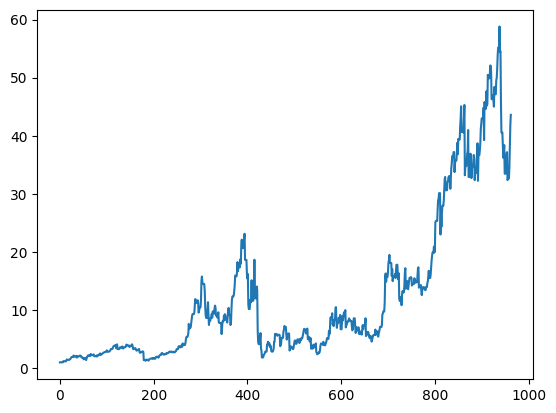

In [17]:
#Graph of PnL over time and print correlation
xPnLOverTime=[]
for k in range(1, len(dayDfs)):
    currentDataArray = np.concatenate(dayDataArray[:k])
    xPnLOverTime.append(algo(np.array([0.005, 1]+list(sortedTotalResults2[0,3:].rows()[0])), currentDataArray)[1])
plt.plot(xPnLOverTime)
#plt.yscale("log")

y = np.array(xPnLOverTime)
x = np.array(range(len(xPnLOverTime)))
correlationCoefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlationCoefficient)

In [18]:
#Functions for graph of PnL for each period with anomolies

def plot(increment, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):

    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            startIndex = (start - beginning).days
            endIndex = (end - beginning).days
            usedDataArray = dayDataArray
        case "week":
            startIndex = (start - beginning).days//7
            endIndex = (end - beginning).days//7
            usedDataArray = weekDataArray
        case "month":
            startIndex = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            endIndex = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            usedDataArray = monthDataArray

    xPnLPerDay=[]
    dates=[]
    for k in range(startIndex, endIndex+1):
        if usedDataArray[k].shape[0]>0:
            result = algo(np.array([0.005, 1]+list(sortedTotalResults2[0,3:].rows()[0])), usedDataArray[k])[1]-1
            xPnLPerDay.append(result)
            dates.append(datetime.datetime.fromtimestamp(usedDataArray[k][0][2] / 1000))
    plt.scatter(dates, xPnLPerDay, s=10)

    meanReturn = np.mean(xPnLPerDay)
    stdDeviation = np.std(xPnLPerDay)
    riskFreeRate = 0.08
    sharpe_ratio = (meanReturn - riskFreeRate) / stdDeviation
    print("Sharpe Ratio:", sharpe_ratio)

def plotAnomalies(increment, resultThreshold=-math.inf, printTrue = False, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):
    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            startIndex = (start - beginning).days
            endIndex = (end - beginning).days
            usedDataArray = dayDataArray
        case "week":
            startIndex = (start - beginning).days//7
            endIndex = (end - beginning).days//7
            usedDataArray = weekDataArray
        case "month":
            startIndex = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            endIndex = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            usedDataArray = monthDataArray

    xPnLPerDay=[]
    dates=[]
    overThreshold = []
    for k in range(startIndex, endIndex+1):
        if usedDataArray[k].shape[0]>0:
            result = algo(np.array([0.005, 1]+list(sortedTotalResults2[0,3:].rows()[0])), usedDataArray[k])[1]-1
            if result > resultThreshold or result < -resultThreshold:
                overThreshold.append((datetime.datetime.fromtimestamp(usedDataArray[k][0][2] / 1000), result))
                xPnLPerDay.append(result)
                dates.append(datetime.datetime.fromtimestamp(usedDataArray[k][0][2] / 1000))
    plt.scatter(dates, xPnLPerDay, s=10)
    if printTrue:
        for k in range(len(overThreshold)):
            print(overThreshold[k][0].date(), overThreshold[k][1])

Sharpe Ratio: -0.6858377158606604


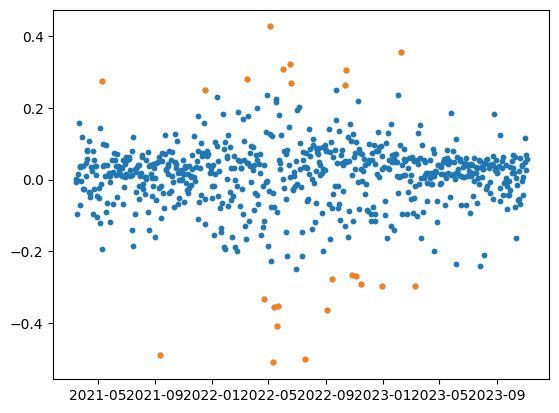

In [19]:
#Start date is 2021-03-15, end date is 2023-11-03
startDate = datetime.datetime(2022, 1, 1)
endDate = datetime.datetime(2023, 11, 3)
increment = "day"
anomaly = 0.25
plot(increment)
plotAnomalies(increment, anomaly, printTrue=False)